# Deep Deterministic Policy Gradient 

Deep Deterministic Policy Gradient (DDPG) is a reinforcement learning technique that combines both Q--learning and Policy gradients. DDPG being an actor-critic technique consists of two models: Actor and Critic. The actor is a policy network that takes the state as input and outputs the exact action (continuous), instead of a probability distribution over actions. The critic is a Q-value network that takes in state and action as input and outputs the Q-value. DDPG is an “off”-policy method. DDPG is used in the continuous action setting and the “deterministic” in DDPG refers to the fact that the actor computes the action directly instead of a probability distribution over actions.
DDPG is used in a continuous action setting and is an improvement over the vanilla actor-critic. [Source](https://towardsdatascience.com/deep-deterministic-policy-gradient-ddpg-theory-and-implementation-747a3010e82f)

## DDPG Schematic

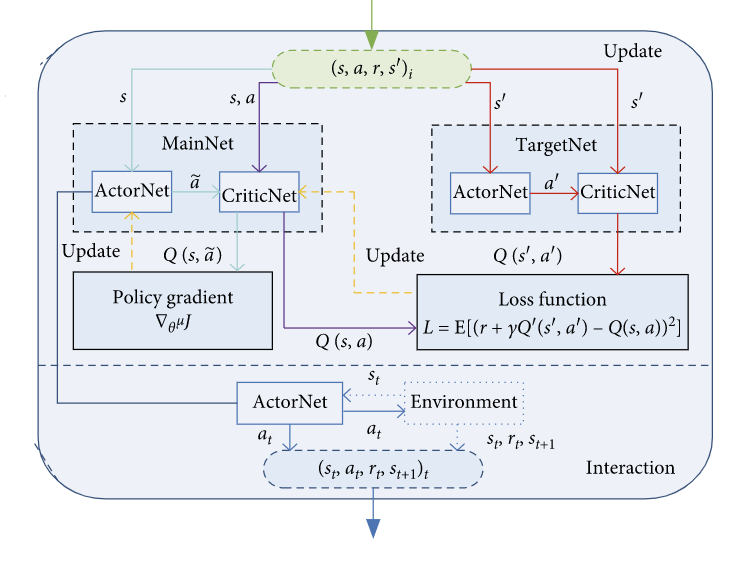

## DDPG Pseudocode

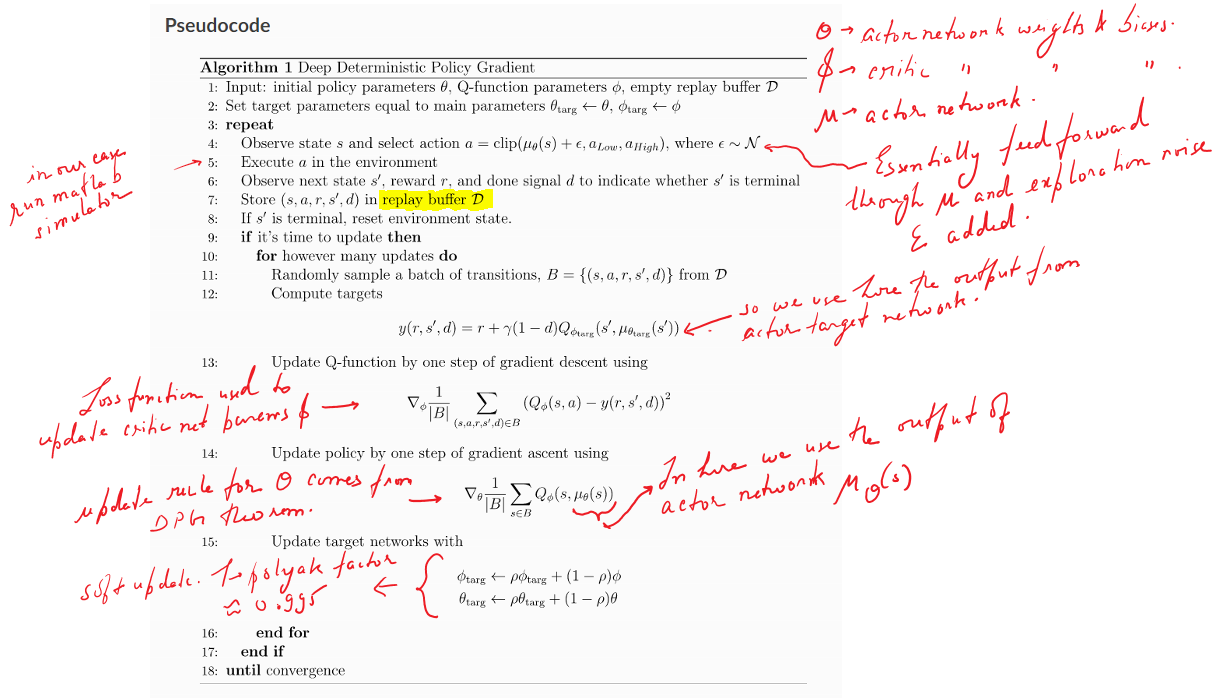

## Important points

Borrowed from sources: [1](https://spinningup.openai.com/en/latest/algorithms/ddpg.html#relevant-papers), 
[2](https://towardsdatascience.com/deep-deterministic-policy-gradient-ddpg-theory-and-implementation-747a3010e82f), 
[3](https://pemami4911.github.io/blog/2016/08/21/ddpg-rl.html), 
[4](https://medium.com/@markus.x.buchholz/deep-reinforcement-learning-deep-deterministic-policy-gradient-ddpg-algoritm-5a823da91b43)
[5](https://towardsdatascience.com/deep-deterministic-policy-gradients-explained-2d94655a9b7b)
[6](https://www.youtube.com/watch?v=_pbd6TCjmaw&ab_channel=OlivierSigaud)
[7](https://www.youtube.com/watch?v=oydExwuuUCw&ab_channel=AylwinWei)
- DDPG uses four neural networks: a Q network, a deterministic policy network, a target Q network, and a target policy network.
- Deep Deterministic Policy Gradient (DDPG) is an algorithm which concurrently learns a Q-function and a policy. It uses off-policy data (replay buffer) and the Bellman equation to learn the Q-function, and uses the Q-function to learn the policy.
- DDPG is adapted specifically for environments with continuous action spaces. DDPG can be thought of as being deep Q-learning for continuous action spaces.
- DDPG trains a deterministic policy in an off-policy way. Because the policy is deterministic, if the agent were to explore on-policy, in the beginning it would probably not try a wide enough variety of actions to find useful learning signals. To make DDPG policies explore better, we add noise to their actions at training time. The authors of the original DDPG paper recommended time-correlated OU noise, but more recent results suggest that uncorrelated, mean-zero Gaussian noise works perfectly well.
- To stabilize learning target networks for both critic and actor are created. These target networks have “soft”-updates based on main networks. In DQN the target gets the main network weights copied over periodically, this is known as a “hard update”. In DDPG we perform a “soft update” where only a fraction of main weights are transferred.
- Update rules for the weights of the actor network come from deterministic policy gradient theorem (see main DPG paper). The critic network is updated from the gradients obtained from the TD error signal.
- On training actor network. "policy term in the expectation is not a distribution over actions. It turns out that all you need is the gradient of the output of the critic network w.r.t. the actions, multiplied by the gradient of the output of the actor network w.r.t. its parameters, averaged over a minibatch."
- DDPG belongs to a class of actor critic methods. In here, we combine the value-based methods such as DQN and policy-based methods such as Reinforce.
- In DDPG, the Actor is used to approximate the optimal policy deterministically. That means we want always to generate the best believed action for any given state. This is unlike a stochastic policy (probability distribution) in which we want the policy to learn a probability distribution over the actions. In DDPG, we want the believed best action every single time we query the actor network. The actor is basically learning the argmax a Q(S, a), which is the best action.
- in DDPG, the Actor directly maps states to actions (the output of the network directly the output) instead of outputting the probability distribution across a discrete action space
- The target networks are time-delayed copies of their original networks that slowly track the learned networks. Using these target value networks greatly improve stability in learning. Here’s why: In methods that do not use target networks, the update equations of the network are interdependent on the values calculated by the network itself, which makes it prone to divergence.
- Why replay buffer?  In optimization asks, we want the data to be independently distributed. This fails to be the case when we optimize a sequential decision process in an on-policy way, because the data then would not be independent of each other. When we store them in a replay buffer and take random batches for training, we overcome this issue.
- For the policy function, our objective is to maximize the expected return:

## Coding Notes

notes about code:
    1. we need classes for 
        OU noise
        replay buffer
        actor
        critic
        agent
    2. we need match norm
    3. we need to think about putting limits on actions
    4. what is being referred to as lower dimensional and higher dimensional in the main paper?
    5. What is pytorch lightning. can i use it here?
    6. Its still in the training mode. so..

In [1]:
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [2]:
class OUActionNoise(object):
    '''
    ** Populate Later with proper comments **
    
    used in the actor class to add some exploration noise to the action selection.
    As described in the paper, we have to add noise to the action in order 
    to ensure exploration. An Ornstein-Uhlenbeck process is chosen because 
    it adds noise in a smooth way, which is suitable for continuous control 
    tasks.
    '''
    def __init__(self, mu, sigma = 0.15, theta = 0.20, dt = 1e-2, x0 = None):
        self.theta  = theta
        self.mu     = mu
        self.sigma  = sigma
        self.dt     = dt
        self.x0     = x0
        self.reset()   # may not be necessary

    def __call__(self):
        """
         Overwriting the call function. 
         The __call__ method enables to write classes where the instances behave 
         like functions and can be called like a function.
        """
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(
                                                            self.mu, self.sigma)

In [3]:
class ReplayBuffer(object):
    """
    ** Populate Later with proper comments**
    """
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory     = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory    = np.zeros((self.mem_size, n_actions))
        self.reward_memory    = np.zeros(self.mem_size)
        self.terminal_memory  = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size # first available position
        self.state_memory[index]     = state
        self.action_memory[index]    = action
        self.reward_memory[index]    = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index]  = 1 - done   
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem  = min(self.mem_cntr, self.mem_size)
        batch    = np.random.choice(max_mem, batch_size)

        states   = self.state_memory[batch]
        actions  = self.action_memory[batch]
        rewards  = self.reward_memory[batch]
        states_  = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

In [4]:
class CriticNetwork(nn.Module):
    """
    ** Populate Later with proper comments **
    """
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='tmp/ddpg'):
        super(CriticNetwork, self).__init__() # calls constrcutor for nn.module
        
        self.input_dims = input_dims
        self.fc1_dims   = fc1_dims
        self.fc2_dims   = fc2_dims 
        self.n_actions  = n_actions
        self.checkpoint_file = os.path.join(chkpt_dir,name+'_ddpg') # checkpoint file
        
        # creating the first hidden layer
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        # perhaps for repeatibility?
        f1       = 1./np.sqrt(self.fc1.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1.bias.data,   -f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims) # batch norm helps with model conv

        # creating the second hidden layer
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        f2       = 1./np.sqrt(self.fc2.weight.data.size()[0])
        T.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data,   -f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims) 
        # the fact that we have a layer norm means that we have
        # to have eval and train functions later
        # https://github.com/pytorch/pytorch/issues/5406#issuecomment-368384202
        # https://discuss.pytorch.org/t/model-eval-gives-incorrect-loss-for-model-with-batchnorm-layers/7561/3
        # https://discuss.pytorch.org/t/what-does-model-eval-do-for-batchnorm-layer/7146/4
        # https://discuss.pytorch.org/t/what-does-model-eval-do-for-batchnorm-layer/7146/2
        # https://stackoverflow.com/a/60018731/5611779
    
        # the critic network is also going to get a action value
        # because the action value function takes in the states and actions 
        # "The actions were not included until the fully-connected layers."
        self.action_value = nn.Linear(self.n_actions, self.fc2_dims) #adding it at the very end of the network. check 
        self.q = nn.Linear(self.fc2_dims, 1) # scalar value so has just one output
        f3     = 0.003  
        T.nn.init.uniform_(self.q.weight.data, -f3, f3)
        T.nn.init.uniform_(self.q.bias.data,   -f3, f3)
        
        # self.parameters() comes from nn.module inheritance
        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state, action):
        state_value = self.fc1(state)
        state_value = self.bn1(state_value)
        state_value = F.relu(state_value)   # here relued after batchnorm
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)

        # In the low-dimensional case, we used batch normalization on the state input 
        # and all layers of the acctor network and all layers of the network prior Q
        # to the action input. 
        # take into accounr the action value
        # action value is getting double relu-ed
        # some people have also tried to work with leaky relu
        action_value       = F.relu(self.action_value(action))
        state_action_value = F.relu(T.add(state_value, action_value))
        state_action_value = self.q(state_action_value)

        return state_action_value

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        # crates a state dictionary, where the keys are the
        # names of the parameters and values are the params themselves
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))    

In [5]:
class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='tmp/ddpg'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims   = fc1_dims
        self.fc2_dims   = fc2_dims
        self.n_actions  = n_actions
        self.checkpoint_file = os.path.join(chkpt_dir,name+'_ddpg')
        
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        f1       = 1./np.sqrt(self.fc1.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1.bias.data,   -f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims)    

        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        f2       = 1./np.sqrt(self.fc2.weight.data.size()[0])
        T.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data,   -f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        self.mu = nn.Linear(self.fc2_dims, self.n_actions)
        f3      = 0.003
        T.nn.init.uniform_(self.mu.weight.data, -f3, f3)
        T.nn.init.uniform_(self.mu.bias.data,   -f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device    = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)    # activate it
        x = T.tanh(self.mu(x)) # for now between -1,1 multiply it by actions bounds for other envs

        return x

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file)) 

In [6]:
class Agent(object):
    def __init__(self, alpha, beta, input_dims, tau, env, gamma=0.99,
                 n_actions=2, max_size=1000000, layer1_size=400,
                 layer2_size=300, batch_size=64):
        self.gamma      = gamma
        self.tau        = tau
        self.memory     = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size

        self.actor  = ActorNetwork(alpha, input_dims, layer1_size,
                                  layer2_size, n_actions=n_actions,
                                  name='Actor')
        self.critic = CriticNetwork(beta, input_dims, layer1_size,
                                    layer2_size, n_actions=n_actions,
                                    name='Critic')

        self.target_actor  = ActorNetwork(alpha, input_dims, layer1_size,
                                         layer2_size, n_actions=n_actions,
                                         name='TargetActor')
        self.target_critic = CriticNetwork(beta, input_dims, layer1_size,
                                           layer2_size, n_actions=n_actions,
                                           name='TargetCritic')

        self.noise = OUActionNoise(mu=np.zeros(n_actions))

        self.update_network_parameters(tau=1) # solves the problem of moving target

    def choose_action(self, observation):
        self.actor.eval() # put actors into eval mode. tell pytroch that you dont wanna calculate statistics for batch norm
        observation = T.tensor(observation, dtype=T.float).to(self.actor.device)
        # get actual actions from the actor network
        mu = self.actor.forward(observation).to(self.actor.device)
        mu_prime = mu + T.tensor(self.noise(),
                                 dtype=T.float).to(self.actor.device)
        self.actor.train()
        return mu_prime.cpu().detach().numpy()


    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        # otherwise sample the memory
        state, action, reward, new_state, done = \
                                      self.memory.sample_buffer(self.batch_size)
        
        # convert to tensors
        state     = T.tensor(state, dtype=T.float).to(self.critic.device)
        action    = T.tensor(action, dtype=T.float).to(self.critic.device)
        new_state = T.tensor(new_state, dtype=T.float).to(self.critic.device)
        reward    = T.tensor(reward, dtype=T.float).to(self.critic.device)
        done      = T.tensor(done).to(self.critic.device)
        
        # send everything to eval mode
        self.target_actor.eval()        # may not be that important for targets
        self.target_critic.eval()       # may not be that important for targets
        self.critic.eval()
        target_actions = self.target_actor.forward(new_state)
        critic_value_ = self.target_critic.forward(new_state, target_actions)
        critic_value = self.critic.forward(state, action)

        target = []
        for j in range(self.batch_size):
            target.append(reward[j] + self.gamma*critic_value_[j]*done[j])
        target = T.tensor(target).to(self.critic.device)
        target = target.view(self.batch_size, 1)

        self.critic.train() # set the critic back into the train mode
        self.critic.optimizer.zero_grad() # whenever you cal gradiends, you do this so that gradients from previous steps dont
        # https://stackoverflow.com/a/48009142/5611779
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()

        self.critic.eval() # for calculation of loss of actor network
        self.actor.optimizer.zero_grad()
        mu = self.actor.forward(state)
        self.actor.train()
        actor_loss = -self.critic.forward(state, mu)
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters() #update netowrk params for target actor and critic

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        # get netword params    
        actor_params         = self.actor.named_parameters()
        critic_params        = self.critic.named_parameters()
        target_actor_params  = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        # turn generator above into dict
        critic_state_dict    = dict(critic_params)
        actor_state_dict     = dict(actor_params)
        target_critic_dict   = dict(target_critic_params)
        target_actor_dict    = dict(target_actor_params)
 
        # copy params
        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                                      (1-tau)*target_critic_dict[name].clone()
        self.target_critic.load_state_dict(critic_state_dict)

        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                                      (1-tau)*target_actor_dict[name].clone()
        self.target_actor.load_state_dict(actor_state_dict)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()

    def check_actor_params(self):
        current_actor_params = self.actor.named_parameters()
        current_actor_dict = dict(current_actor_params)
        original_actor_dict = dict(self.original_actor.named_parameters())
        original_critic_dict = dict(self.original_critic.named_parameters())
        current_critic_params = self.critic.named_parameters()
        current_critic_dict = dict(current_critic_params)
        print('Checking Actor parameters')

        for param in current_actor_dict:
            print(param, T.equal(original_actor_dict[param], current_actor_dict[param]))
        print('Checking critic parameters')
        for param in current_critic_dict:
            print(param, T.equal(original_critic_dict[param], current_critic_dict[param]))
        input()    

episode  0 score -349.14 trailing 100 games avg -349.141
episode  1 score -524.80 trailing 100 games avg -436.970
episode  2 score -200.73 trailing 100 games avg -358.225
episode  3 score -145.61 trailing 100 games avg -305.071
episode  4 score -126.40 trailing 100 games avg -269.336
episode  5 score -96.99 trailing 100 games avg -240.612
episode  6 score -112.84 trailing 100 games avg -222.359
episode  7 score -32.00 trailing 100 games avg -198.564
episode  8 score -147.12 trailing 100 games avg -192.847
episode  9 score -127.63 trailing 100 games avg -186.326
episode  10 score -134.45 trailing 100 games avg -181.610
episode  11 score -171.48 trailing 100 games avg -180.765
episode  12 score -160.96 trailing 100 games avg -179.242
episode  13 score -202.36 trailing 100 games avg -180.893
episode  14 score -101.69 trailing 100 games avg -175.613
episode  15 score -78.76 trailing 100 games avg -169.559
episode  16 score -51.90 trailing 100 games avg -162.638
episode  17 score -343.10 tr

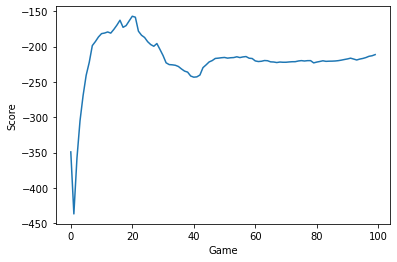

In [14]:
# import Agent
import gym
import numpy as np
from utils_ import plotLearning

env = gym.make('LunarLanderContinuous-v2')
agent = Agent(alpha=0.000025, beta=0.00025, input_dims=[8], tau=0.001, env=env,
              batch_size=64,  layer1_size=400, layer2_size=300, n_actions=2)

#agent.load_models()
np.random.seed(0)

score_history = []
for i in range(100):
    obs = env.reset()
    done = False
    score = 0
    while not done:
        act = agent.choose_action(obs)
        new_state, reward, done, info = env.step(act)
        agent.remember(obs, act, reward, new_state, int(done))
        agent.learn()
        score += reward
        obs = new_state
        #env.render()
    score_history.append(score)

    #if i % 25 == 0:
    #    agent.save_models()

    print('episode ', i, 'score %.2f' % score,
          'trailing 100 games avg %.3f' % np.mean(score_history[-100:]))

filename = 'LunarLander-alpha000025-beta00025-400-300.png'
plotLearning(score_history, filename, window=100)